**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Chargement des données](#toc1_1_)    
  - [Préparation des données](#toc1_2_)    
- [Approches Bag-of-words](#toc2_)    
  - [🚧 Expliquer ce que c'est](#toc2_1_)    
  - [Méthode de scoring](#toc2_2_)    
- [TF-IDF](#toc3_)    
- [CountVectorizer](#toc4_)    
- [LDA](#toc5_)    
  - [Topic → prédiction de mots](#toc5_1_)    
- [NMF](#toc6_)    
- [🚧 Conclusion](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
import os
import logging
import time

# DS
import numpy as np
import pandas as pd
import dill as pickle

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import gensim
import pyLDAvis
import pyLDAvis.gensim

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from Levenshtein import ratio

# home made functions from the src folder
from src.scrap_and_clean import init_data
from src.models import results_from_vec_matrix
from src.models import get_5_tags_from_matrix
from src.models import score_reduce
from src.models import plot_model
from src.models import vect_data
from src.models import eval_lda_n_topics
from src.models import get_topics
from src.models import topic_weights_df
from src.models import topic_predict

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## <a id='toc1_1_'></a>[Chargement des données](#toc0_)

In [2]:
df_pp = init_data()

INFO:root:✅ Preprocessed data loaded


In [3]:
print(f"DF shape: {df_pp.shape}")
display(df_pp.head())

DF shape: (49975, 10)


,doc_bow,tags,score,answers,views,date,title_bow,title,body_bow,body
0,itms-91053 missing api declaration privacy sud...,ios app-store plist,24,7,3092,2024-03-14 22:55:18,itms-91053 missing api declaration privacy,ITMS-91053: Missing API declaration - Privacy,suddent successful build apple,<p>Why am I all of a suddent getting this on s...
1,builtin sorted slower list containing descendi...,python algorithm performance sorting time-comp...,28,2,2699,2024-03-05 15:21:50,builtin sorted slower list containing descendi...,Why is builtin sorted() slower for a list cont...,sorted four similar list list consistently tak...,<p>I sorted four similar lists. List <code>d</...
2,std :shared_mutex :unlock_shared block though ...,c++ windows multithreading stl,26,5,1388,2024-03-01 23:09:59,std :shared_mutex :unlock_shared block though ...,std::shared_mutex::unlock_shared() blocks even...,team encountered deadlock suspect bug windows ...,<p>My team has encountered a deadlock that I s...
3,rules nullptr init unique_ptr c++ compiles msv...,c++ visual-c++ language-lawyer unique-ptr c++23,15,1,490,2024-02-22 11:29:42,rules nullptr init unique_ptr c++,Did the rules for nullptr init of unique_ptr c...,compiles msvc c++ mode failes c++ mode current...,<p>This code compiles with MSVC from VS 2022 i...
4,order elf relocation applied specified conside...,c++ elf dynamic-linking abi,16,1,1746,2024-02-19 21:42:03,order elf relocation applied specified,Where is the order in which ELF relocations ar...,consider linux system use_message.cpp libmessa...,<p>Consider the following two files on a Linux...


Utilisation des données indispensables seulement

In [4]:
df = df_pp[["doc_bow", "tags"]]
print(f"DF shape: {df.shape}")

DF shape: (49975, 2)


🚧 VOIR SI UTILE APRES -> Création d'un jeu de données centré sur les tags

In [5]:
df_exploded = df_pp.copy()
df_exploded["tags"] = df_exploded["tags"].apply(lambda x: x.split())
df_exploded = df_exploded.explode("tags")
print(f"DF shape (exploded on tags): {df_exploded.shape}")

DF shape (exploded on tags): (216204, 10)


## <a id='toc1_2_'></a>[Préparation des données](#toc0_)

Séparation de 1000 documents pour les tests, le reste pour l'entraînement des modèles.

In [6]:
random_state = 42
test_size = 1000

# X, y, train, test split
X_train, X_test, y_train, y_test = train_test_split(
    df["doc_bow"], df["tags"], test_size=test_size, random_state=random_state
)

# <a id='toc2_'></a>[Approches Bag-of-words](#toc0_)

> RAPPEL :  
> La colonne `doc_bow` est un ***bag of words*** (abrégé *BOW*), dans lequel tous les mots d'un document y sont représentés, sans aucune distinction (ni ordre).  

Cette approche permet de représenter chaque document par un vecteur de la taille du vocabulaire entier (corpus), soit par un comptage soit par une fréquence (cf. ci-après)

## <a id='toc2_2_'></a>[🚧 Méthode de scoring](#toc0_)

#### 🚧 on garde ? si oui, on réexplique ?

On cherche à évaluer l'efficacité d'un modèle qui renvoie deux listes de termes, sans toutefois appliquer de solution binaire comme la présence ou non du terme exact dans les deux listes, au vu de la diversité des termes employés.

Un moyen simple d'utiliser le meilleur ratio de Levenshtein (similarité entre chaînes de caractères) avec un seuil cohérent et de le diviser par le nombre de termes.

> Une similarité de 70% permet par exemple de mettre une similarité de 0 entre 'c' et 'c#', une similarité de 0.71 entre 'spring' et 'spring-boot' mais de 0 entre 'spring-boot' et 'boot'.



- le score maximum de 1 équivaut à tous les termes exacts trouvés,
- le minimum de 0 signifie qu'il n'y a pas eu de terme suffisamment proche pour passer le seuil défini

In [7]:
def score_terms(pred_words, target_words, cutoff=0.7) -> float:
    """Return a score of terms similarity between 2 lists of strings"""
    score = 0
    for p_w in pred_words:
        score += max(ratio(t, p_w, score_cutoff=cutoff) for t in target_words)
    score = np.round(score / len(target_words), 3)

    return score

# <a id='toc3_'></a>[TF-IDF](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Un modèle simple de prédictions se basant sur les fréquences de monogrammes présents dans un corpus.

#### 🚧 Expliquer modèle

Entraînement du modèle sur l'échantillon d'entraînement

In [8]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"\S+", min_df=10)
tfidf_fitted = tfidf_vectorizer.fit(X_train)
tfidf_names = tfidf_vectorizer.get_feature_names_out()

Exemple sur un document du test

In [9]:
# get a random example in test set
random_i = 42
example_doc_index = X_test.index[random_i]
doc = X_test[example_doc_index]

# get target
y = y_test[example_doc_index].split(" ")

# predict
X = tfidf_fitted.transform(X_test)
doc_transformed = X[random_i]

# original data
origin_doc = df_pp.iloc[example_doc_index]

# display predictions
predictions = results_from_vec_matrix(tfidf_names, doc_transformed)
pred_words = [p[0] for p in predictions]


print(f"🔹 Original document:\n\t{origin_doc[['title', 'body']].values}\n")
print(f"🔹 Preprocessed data:\n\t{doc}\n")
print(f"🔹 Predictions:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{y}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, y)}\n")

🔹 Original document:
	['Can I find an element using regex with Python and Selenium?'
 "<p>I need to click a dropdown list and click a hidden element with in it. the html will be generated by javascript and I won't know the id or class name but I will know it will have a phrase in it. Can I find and element by regex and then click it with selenium?</p>\n"]

🔹 Preprocessed data:
	find element regex python selenium click dropdown list click hidden element html generated javascript class name phrase find element regex click selenium

🔹 Predictions:
	['regex', 'click', 'element', 'selenium', 'phrase']

🔹 Targetted tags:
	['javascript', 'python', 'html', 'regex', 'selenium']

🔹 Score:
	0.4



Application sur nos données de test

In [10]:
results = score_reduce(tfidf_names, tfidf_fitted.transform(X_test), y_test)

# check with sample
print("Check with example sample")
print(results[1][random_i])
print(results[2][random_i])

Score:  0.262 - Duration:  11.0
Check with example sample
['regex', 'click', 'element', 'selenium', 'phrase']
0.4


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fnam

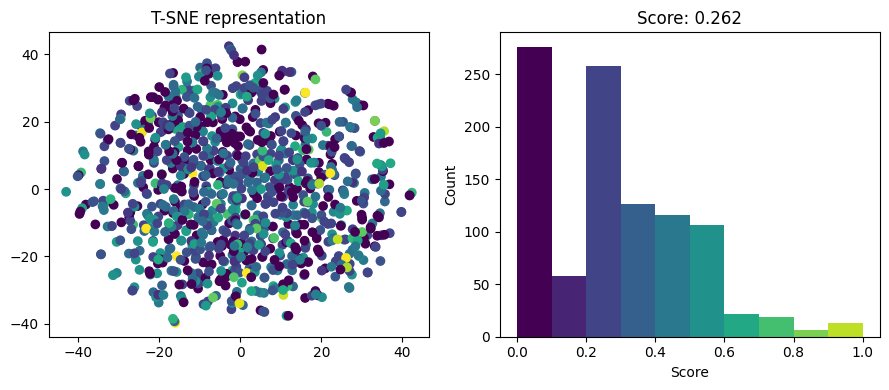

In [11]:
plot_model(results[0], results[2], results[3])

De par son fonctionnement, **TF-IDF ne propose pas les tags les plus fréquents**, tels que les noms de langages informatiques ou bibliothèques régulièrement utilisées : c'est là une des limites de cette approche simple.

# <a id='toc4_'></a>[CountVectorizer](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

#### 🚧 Expliquer modèle

Modèle de comptage vectoriel avec au moins 10 occurrences dans le corpus :

In [12]:
count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=10)

Entraînement

In [13]:
cv_fitted = count_vectorizer.fit(X_train)
cv_names = count_vectorizer.get_feature_names_out()

Résultats sur l'échantillon de test

Score:  0.234 - Duration:  8.0


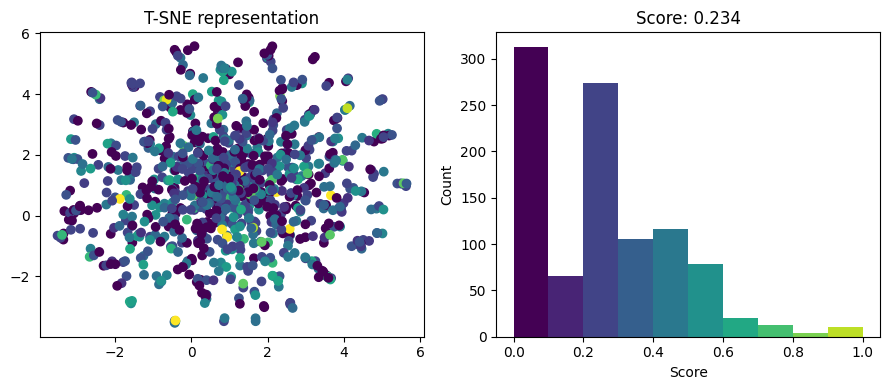

In [14]:
results = score_reduce(cv_names, cv_fitted.transform(X_test), y_test)
plot_model(results[0], results[2], results[3])

# <a id='toc5_'></a>[LDA](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)

[pyLDAvis for visualization](https://medium.com/@sherryqixuan/topic-modeling-and-pyldavis-visualization-86a543e21f58)

[LDA Gensim 1](https://radimrehurek.com/gensim/wiki.html#latent-dirichlet-allocation)
[LDA Gensim 2](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel)

[❤️ LDA in TDS](https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd)

#### 🚧 Expliquer modèle

LDA prend une matrice de vecteurs en entrée : utilisation de CountVectorizer

In [15]:
cv = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=10)
cv_data = cv.fit_transform(X_train)
cv_names = cv.get_feature_names_out()

Évaluation de la perplexité pour déterminer un nombre de sujets adequat (processus long ≈ 10' : à lancer une seule fois)

In [16]:
%%script echo "no execution" # comment line for cell execution
perplexities = eval_lda_n_topics(random_state, cv_data)

DEBUG:asyncio:Using selector: EpollSelector


no execution # comment line for cell execution


<img src="outputs/LDA%20perplexities.png" width=600>

Selon la documentation, plus la perplexité est basse, plus le modèle est efficace.  
Le choix a été fait de tester sur des nombres cohérents de sujets : assez nombreux pour ne pas trop baisser le nombre de mots-clés, assez restreints pour qu'ils restent distincts et interprétables.

D'après ces résultats, **réduire les questions à 20 sujets principaux paraît le plus judicieux**.

In [17]:
# define a maximum number of topics (each represented by some words)
n_topics = 20

# LDA model
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=random_state,
)

Entraînement

In [18]:
lda.fit(cv_data)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=42)

Affichage des topics

In [19]:
n_top_words = 10
topics = get_topics(lda, cv_names, n_top_words)
topics

['server user request api app client web service token access',
 'array element list key number plot algorithm vector set map',
 'text header search add location option fragment custom design box',
 'django bar color aws flutter background notification set disable widget',
 'class java project interface parent maven configuration method properties dependency',
 'time google video task loop app stream second play crash',
 'object function component get json data react firebase event call',
 'function type c++ compiler compile gcc types program c standard',
 'test spring exception method boot unit service testing controller mock',
 'string database table data query sql field format name entity',
 'ios xcode app swift sdk target b apple cpu r',
 'project studio visual folder build node window npm app typescript',
 'version command python module package get script install build installed',
 'image view page button html click angular display browser screen',
 'windows certificate chrome get

Application aux données de test

In [20]:
# predict
X_cv = cv.transform(X_test)
X_lda = lda.transform(X_cv)

# 🦄🦄 CHECKPOINT 🦄🦄

In [21]:
# visualize with pyLDAvis
pyLDAvis.enable_notebook()

In [22]:
import pyLDAvis.lda_model

# cv_pp = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=10)
# cv_pp_data = cv.fit_transform(X_train)

# lda_model = LatentDirichletAllocation(n_components=20, max_iter=5, learning_method="online", learning_offset=50.0, random_state=random_state)
# lda_model.fit(cv_pp_data)

dtm = np.matrix(X_train)
vis = pyLDAvis.lda_model.prepare(lda, dtm, cv, mds='tsne')

AssertionError: Term frequencies and vocabulary are of different sizes, 48975 != 9136.

### Avec Gensim

In [ ]:
# create dictionary and corpus
# dictionary = gensim.corpora.Dictionary([d.split() for d in X_train])
# corpus = [dictionary.doc2bow(doc.split()) for doc in X_train]

# lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=20)

# import pyLDAvis.gensim
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=True)

In [ ]:
# pyLDAvis.display(vis)

In [ ]:
pyLDAvis.save_html(vis, "outputs/LDA_topics.html")

In [ ]:
stop

Essai sur un exemple

In [ ]:
n_top_topics = 5  # best topics for each input

# get the n top topics
top_topics = X_lda[random_i].argsort()[: -n_top_topics - 1 : -1]
# get its weights
top_topics_weights = X_lda[random_i][top_topics]

print(f"🔹 Original document:\n\t{origin_doc[['title', 'body']].values}\n")
print(f"🔹 Preprocessed data:\n\t{doc}\n")
# predict topics
print(f"🔹 Top {n_top_topics} topics:")
for topic in top_topics:
    print(f"\tTopic {topic} (weight {X_lda[random_i][topic]}):\n\t\t{topics[topic]}")

🔹 Original document:
	['Can I find an element using regex with Python and Selenium?'
 "<p>I need to click a dropdown list and click a hidden element with in it. the html will be generated by javascript and I won't know the id or class name but I will know it will have a phrase in it. Can I find and element by regex and then click it with selenium?</p>\n"]

🔹 Preprocessed data:
	find element regex python selenium click dropdown list click hidden element html generated javascript class name phrase find element regex click selenium

🔹 Top 5 topics:
	Topic 1 (weight 0.27396055875817643):
		array element list key number plot algorithm vector set map
	Topic 2 (weight 0.2161810021359828):
		text header search add location option fragment custom design box
	Topic 13 (weight 0.17620185472022845):
		image view page button html click angular display browser screen
	Topic 14 (weight 0.12752335285953495):
		windows certificate chrome get github local debug download update open
	Topic 4 (weight 0.07

La visualisation des topics est efficace mais on souhaite la prédiction de 5 tags à partir des topics.

## <a id='toc5_1_'></a>[Topic → prédiction de mots](#toc0_)

Pour cela, il est possible de pondérer le poids de chacun des 10 meilleurs mots d'un topic par la probabilité du topic lui-même, puis de récupérer les 5 meilleurs mots qui en ressortent.

Pour chaque topic, sauvegarde des 10 meilleurs poids et mots associés dans un dataframe :

In [ ]:
lda_df = topic_weights_df(lda, cv_names)
lda_df.head()

Prédictions pour l'échantillon de test

In [ ]:
X_results = [topic_predict(lda_df, xi) for xi in X_lda]

Sur le document d'exemple

In [ ]:
pred_words = X_results[random_i][1]
y = y_test[example_doc_index]

print(f"🔹 Words prediction:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{y}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, y)}\n")

Résultats sur l'échantillon de test

In [ ]:
results = score_reduce(cv_names, X_lda, y_test, model_type="topic", model=lda)
plot_model(results[0], results[2], results[3])

# <a id='toc6_'></a>[NMF](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

#### 🚧 Expliquer modèle

In [ ]:
# define a maximum number of topics (each represented by some words)
n_topics = 20

nmf = NMF(n_components=n_topics)

NMF prend une matrice de vecteurs en entrée : utilisation de TF-IDF

In [ ]:
tfidf = TfidfVectorizer(token_pattern=r"\S+", min_df=10)
tfidf_data = tfidf.fit_transform(X_train)
tfidf_names = tfidf.get_feature_names_out()

Entraînement

In [ ]:
nmf.fit(tfidf_data)

In [ ]:
n_top_words = 10
topics = get_topics(nmf, tfidf_names, n_top_words)
topics

Pour chaque topic, sauvegarde des 10 meilleurs poids et mots associés dans un dataframe :

In [ ]:
nmf_df = topic_weights_df(nmf, tfidf_names)
nmf_df.head()

Application aux données de test

In [ ]:
# predict
X_tfidf = tfidf.transform(X_test)
X_nmf = nmf.transform(X_tfidf)

Prédictions pour l'échantillon de test

In [ ]:
X_results = [topic_predict(nmf_df, xi) for xi in X_nmf]

Sur le document d'exemple

In [ ]:
pred_words = X_results[example_doc_index][1]
y = y_test[example_doc_index]

print(f"🔹 Words prediction:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{y}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, y)}\n")

Résultats sur l'échantillon de test

In [ ]:
results = score_reduce(tfidf_names, X_nmf, y_test, model_type="topic", model=nmf)
plot_model(results[0], results[2], results[3])

# <a id='toc7_'></a>[🚧 Conclusion](#toc0_)